<a href="https://colab.research.google.com/github/yanada1307/14IF_Multi-label-Emotion-Classification/blob/main/Proyek_PBA_Sprinkle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROYEK PBA KELOMPOK SPRINKLE**
**Pemrosesan Bahasa Alami**

**Kamis, 18 November 2021**


1.   11S18015 - Yanada Sari Br Situmorang
2.   11S18002 - Putri Era Waty Bakara
3.   11S18010 - N. Priskila Napitupulu
4.   11S18012 - Suryani Vebhitry Siahaan
5.   11S18038 - Grace Winda N Naibaho
6.   11S18063 - Elyta Junetta Siregar





---

In [3]:
!pip3 install datasets transformers -q

     |████████████████████████████████| 290 kB 5.4 MB/s 
     |████████████████████████████████| 3.1 MB 38.2 MB/s 
     |████████████████████████████████| 243 kB 60.0 MB/s 
     |████████████████████████████████| 132 kB 62.2 MB/s 
     |████████████████████████████████| 1.1 MB 50.3 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 42.7 MB/s 
     |████████████████████████████████| 3.3 MB 39.5 MB/s 
     |████████████████████████████████| 596 kB 46.3 MB/s 
     |████████████████████████████████| 192 kB 44.4 MB/s 
     |████████████████████████████████| 160 kB 58.1 MB/s 
     |████████████████████████████████| 271 kB 65.1 MB/s 


In [4]:
!pip install tez

In [5]:
from datasets import load_dataset

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import os
import random
import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

**Load dataset go_emotions dan split menjadi train, validation, dan test**

In [6]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No config specified, defaulting to: go_emotions/simplified


Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/201k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

In [8]:
print(train.shape, valid.shape, test.shape)

(43410, 3) (5426, 3) (5427, 3)


In [9]:
train.head() 

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


**Convert dataset menjadi representasi one-hot**

In [10]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [11]:
def one_hot_labels(df):
    dict_labels= []
    for i in tqdm(range(len(df))):
        d = [0]*n_labels
        labels = df.iloc[i]["labels"]
        
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
        
    return pd.DataFrame(dict_labels)

In [12]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [13]:
train_oh_labels.shape

(43410, 28)

In [14]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

**Cek kembali datanya**

In [15]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [16]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


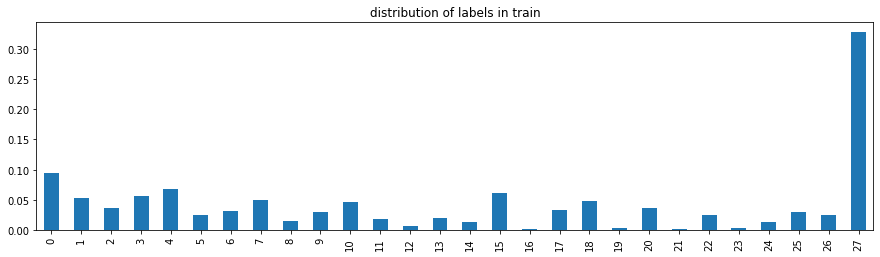

In [17]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

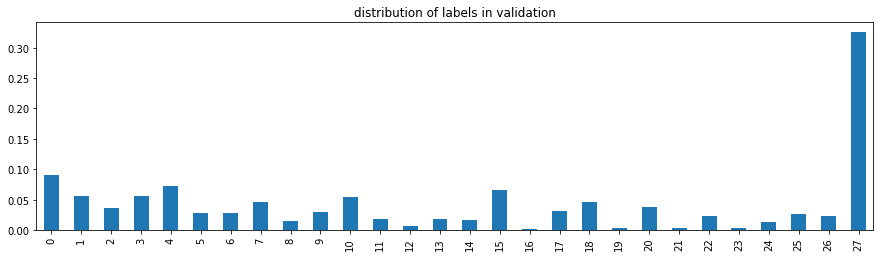

In [18]:
fig = plt.figure(figsize=(15, 13))

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

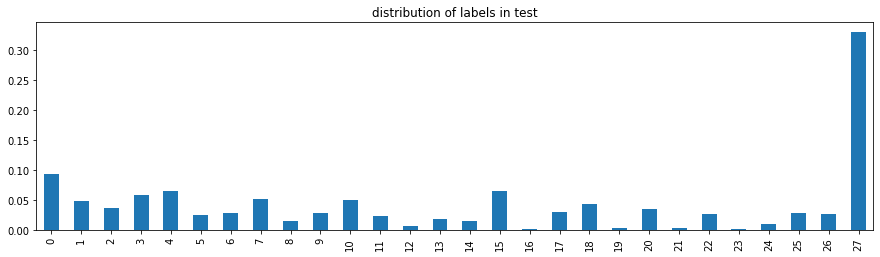

In [19]:
fig = plt.figure(figsize=(15, 13))

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [20]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

**Beberapa ulasan dari emotions**

In [21]:
inspect_data(0)

examples from admiration

Mind boggling. Truly. This is the same deal SHE negotiated. Why didn't she find out if her party would back it BEFORE she signed it?
---
What a great response!!
---
I'm just living through you as you use shower comebacks in real life. Glorious...
---
Yeah I had a lot of respect for him in that moment.
---
Oh well, very nice then :)
---


In [22]:
inspect_data(1)

examples from amusement

[NAME]. Instantly went to moving the goalpost. Looks like my bet was a winner.
---
A TECHNICAL Lmao.
---
Welcome back you two lol
---
Your idea of the supposed limitations of bots is actually hilarious.
---
I used to get messages from neck fetishists a lot because I have a long neck lmao I didn't even realize that was a thing
---


In [23]:
inspect_data(2)

examples from anger

Watching this makes me angry.
---
Hey [NAME]! **TRY DRAWING TWO CARDS NOW, YOU STUPID FUCKING BASTARD!!**
---
I don't care anymore.
---
[NAME]’ ego has turned him into such a bully. He seems to get off lately on witch-hunting and encouraging his “sisters” to harass people.
---
LETS FUCKING GOOOOO
---


In [24]:
inspect_data(3)

examples from annoyance

Just don't bring up the Manga Carta. Really uncomfortable for my history class.
---
Damn, I was really hoping for some comeuppance at the end, but at least you no longer have her for a boss, so silver lining.
---
Dirty Southern Wankers
---
No need to bully me.
---
Yup. Was so annoyed to see this making the rounds yesterday.
---


In [25]:
inspect_data(4)

examples from approval

Just hanging out at UQ St Lucia is pretty cool.
---
INTJ here, I agree with this ^^^ (Him)
---
Police can amend docs, they can’t change them. Even if it’s a name
---
Eventually I would have to land another queen to stop the target from arranging marriages themselves.
---
It's a careful boundary between them seeing you as "one of those parents" and taking you seriously.
---


In [26]:
inspect_data(5)

examples from caring

I’m not sure what to make of any of this but stay strong, friend. You’ll get through this eventually!
---
We're a community, like it or not. This came from us and we need to hold eachother to a higher standard of behavior.
---
I think the dog is mostly worried about being fed and let outside when the last of the humans stop coming home.
---
If it's legal where you live, then it doesn't really matter what anyone thinks.
---
I don't want [NAME] to lose her job is all. She's a rare teacher who loves her job and students once you help her out and all..
---


In [27]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
 
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]

        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }